# Effects of filter parameters on phase-amplitude coupling

#### This notebook visualizes the effects of various filter parameters on calculated beta-high gamma phase-amplitude coupling (PAC) in an example data set.

Download the notebook and data, correct the location of the data in the 'pacpretty' method, and run the interactive plot on the bottom.

Use the sliders to adjust the filter parameters and observe their effects on PAC estimation. For example, PAC decreases with increasing window length for the gamma filter. Interestingly, the PAC measurements are relatively insensitive to expanding the transition bands of the filter to be very large.

Imports

In [1]:
from __future__ import division
import numpy as np
import math
from scipy.signal import filtfilt, firwin2, freqz, hilbert
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.html.widgets import interactive, FloatSliderWidget, fixed
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Helper functions

In [2]:
def power_two(n):
    '''
    Calculate the next power of 2 above the number provided
    '''
    return 2**(int(math.log(n, 2))+1)


def fasthilbert(x, axis=-1):
    '''
    Redefinition of scipy.signal.hilbert, which is very slow for some lengths
    of the signal x. This version zero-pads the signal to the next power of 2
    for speed.
    '''
    x = np.array(x)
    N = x.shape[axis]
    N2 = power_two(len(x))
    Xf = np.fft.fft(x, N2, axis=axis)
    h = np.zeros(N2)
    h[0] = 1
    h[1:(N2 + 1) // 2] = 2
        
    x = np.fft.ifft(Xf * h, axis=axis)
    return x[:N]

def rmv_edge(x,win):
    '''
    Remove the edge effects from a filtered signal
    '''
    return x[np.int(win):-np.int(win)]

def pacpretty(beta_center_freq,beta_bandwidth,beta_transition,beta_cycles,
              gamma_center_freq,gamma_bandwidth,gamma_transition,gamma_cycles):
    '''
    Same as PAC function but only with long variable names of interest
    '''
    data=np.load('C:/gh/neurosrc/pac/exampledata.npy')
    pac(data,beta_center_freq,beta_bandwidth,gamma_center_freq,gamma_bandwidth,
        beta_cycles,beta_transition,gamma_cycles,gamma_transition)

PAC function

In [3]:
def pac(x, bcf = 21.5, bbw = 17, gcf = 140, gbw = 60,
        bcy = 5, btw = .15, gcy = .5, gtw = .15,
        gcy_g = False, Fs = 1000):
    '''
    Calculate phase-amplitude coupling
    
    Parameters
    ----------
    x : array
        temporal signal
    bcf : float
        center frequency of the low frequency band
    bbw : float
        bandwidth of the low frequency band
    gcf : float
        center frequency of the high frequency band
    gbw : float
        bandwidth of the high frequency band
    bcy : float
        width of filtering window of the low frequency band in terms of the 
        number of cycles of the center frequency of that band
    btw : float (0<x<1)
        transition width of the low frequency band filter as a fraction of
        the frequencies of the passband
    gcy : float
        width of filtering window of the high frequency band in terms of the 
        number of cycles of the center frequency of that band or the beta band
        (depending on gcy_g value)
    gtw : float (0<x<1)
        transition width of the high frequency band filter as a fraction of
        the frequencies of the passband
    gcy_g : boolean
        True : the width of the high frequency band filter is measured as the 
        number of cycles of the center frequency in the high frequency band
        False : the width of the high frequency band filter is measured as the 
        number of cycles of the center frequency in the low frequency band 
    Fs : integer
        sampling rate
  
    Returns
    -------
    amp : array
        Time series of the analytic amplitude of the upper frequency band
    pha : array
        Time series of the analytic phase of the lower frequency band
    pac : numeric
        PAC value
    and now other things
    '''
    
    # Process parameters
    flo = (bcf - bbw / 2.0, bcf + bbw / 2.0)
    fhi = (gcf - gbw / 2.0, gcf + gbw / 2.0)
    nyq = Fs/2
    
    # Beta filter
    Ntapsb = np.floor(bcy*Fs/bcf)
    f = [0, (1-btw)*flo[0]/nyq, flo[0]/nyq, flo[1]/nyq, (1+btw)*flo[1]/nyq, 1]
    m = [0,0,1,1,0,0]
    tapsb = firwin2(Ntapsb, f, m)
    xb = filtfilt(tapsb,[1],x)
    
    # Gamma filter
    if gcy_g:
        Ntapsg = np.floor(gcy*Fs/gcf)
    else:
        Ntapsg = np.floor(gcy*Fs/bcf)
    f = [0, (1-gtw)*fhi[0]/nyq, fhi[0]/nyq, fhi[1]/nyq, (1+gtw)*fhi[1]/nyq, 1]
    m = [0,0,1,1,0,0]
    tapsg = firwin2(Ntapsg, f, m)
    xg = filtfilt(tapsg,[1],x)
    xb = rmv_edge(xb,np.ceil(np.max([Ntapsb,Ntapsg])/2.0))
    xg = rmv_edge(xg,np.ceil(np.max([Ntapsb,Ntapsg])/2.0))
    
    # Frequency responses
    [wb,hb] = freqz(tapsb)
    wb = wb*nyq/np.pi
    [wg,hg] = freqz(tapsg)
    wg = wg*nyq/np.pi
    
    # Analytic amplitude and phase time signals
    amp = np.abs(fasthilbert(xg))
    pha = np.angle(fasthilbert(xb))
    phadeg = np.degrees(pha)
    
    # Calculate PAC: modulation index (Tort, 2008)
    bin_phase_lo = np.arange(-180,180,20)
    binned_meanA = np.zeros(len(bin_phase_lo))
    for b in range(len(bin_phase_lo)):
        phaserange = np.logical_and(phadeg>=bin_phase_lo[b],phadeg<(bin_phase_lo[b]+20))
        binned_meanA[b] = np.mean(amp[phaserange])
        
    p_j = np.zeros(len(bin_phase_lo))
    for b in range(len(bin_phase_lo)):
        p_j[b] = binned_meanA[b]/sum(binned_meanA)
        
    H = -sum(np.multiply(p_j,np.log10(p_j)))
    Hmax = np.log10(18)
    pac_mi = (Hmax-H)/Hmax
        
    # Calculate PAC: phase-locking value (Tort, 2010)
    amp_beta = filtfilt(tapsb,[1],amp)
    amp_pha = np.angle(fasthilbert(amp_beta))
    pac_plv = np.abs(np.sum(np.exp(1j * (pha - amp_pha)))) / len(pha)
    
    makeplots(amp, pha, pac_mi, tapsb, tapsg, wb, hb, wg, hg, bin_phase_lo, binned_meanA, pac_plv)
    
    return

Plotting function

In [4]:
def makeplots(amp, pha, pac_mi, tapsb, tapsg, wb, hb, wg, hg, bin_phase_lo, binned_meanA, pac_plv):
    '''
    Make plots: 
    1. Beta filter impulse response
    2. Beta filter frequency response
    3. Gamma filter impulse response
    4. Gamma filter frequency response
    5. Histogram of gamma power over beta cycle
    '''
    
    Ntapsb = len(tapsb)
    Ntapsg = len(tapsg)
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,1)
    plt.cla()
    plt.plot(tapsb)
    plt.ylabel('Beta impulse response')
    plt.annotate('Window length: '+np.str(np.int(Ntapsb)),
                xy=(.02, .9),  xycoords='axes fraction')  
    
    plt.subplot(2,3,2)
    plt.cla()
    plt.plot(wb,abs(hb))
    plt.xlim([0,50])
    plt.ylim([0,1.05])
    plt.ylabel('Amplitude (dB)')
    
    plt.subplot(2,3,4)
    plt.cla()
    plt.plot(tapsg)
    plt.xlabel('samples (ms)')
    plt.ylabel('Gamma impulse response')
    plt.annotate('Window length: '+np.str(np.int(Ntapsg)),
                xy=(.02, .9),  xycoords='axes fraction') 
    plt.subplot(2,3,5)
    plt.cla()
    plt.plot(wg,abs(hg))
    plt.ylim([0,1.05])
    plt.xlim([0,300])
    plt.xlabel('f (Hz)')
    plt.ylabel('Amplitude (dB)')
    
    plt.subplot(1,3,3)
    plt.cla()
    plt.bar(bin_phase_lo,binned_meanA,20)
    plt.ylabel('Mean gamma power')
    plt.xlabel('Beta phase (degrees)')
    plt.xlim([-180,180])
    plt.xticks(np.arange(-180,181,60))
    plt.annotate('\nMI = '+np.str(np.round(pac_mi,4))+'\nPLV = '+np.str(np.round(pac_plv,2)),
                xy=(.02, .9),  xycoords='axes fraction')  
    plt.show()
    
    return

# Interactive plots

####Plots:

Left column: impulse response for the beta filter (top) and gamma filter (bottom).

Center column: frequency response for the beta filter (top) and gamma filter (bottom).

Right column: Distribution of gamma power over the beta cycle

#### Parameters:

beta_center_freq: Center frequency of the beta band (Hz)

beta_bandwidth: Width of the beta band (Hz)
    
beta_transition: Transition width of the beta band as a fraction of the frequencies of the passband

beta_cycles : Width of the beta window in terms of the number of cycles of the beta center frequency

gamma_center_freq: Center frequency of the gamma band (Hz)

gamma_bandwidth: Width of the gamma band (Hz)
    
gamma_transition: Transition width of the gamma band as a fraction of the frequencies of the passband

gamma_cycles : Width of the gamma window in terms of the number of cycles of the beta center frequency

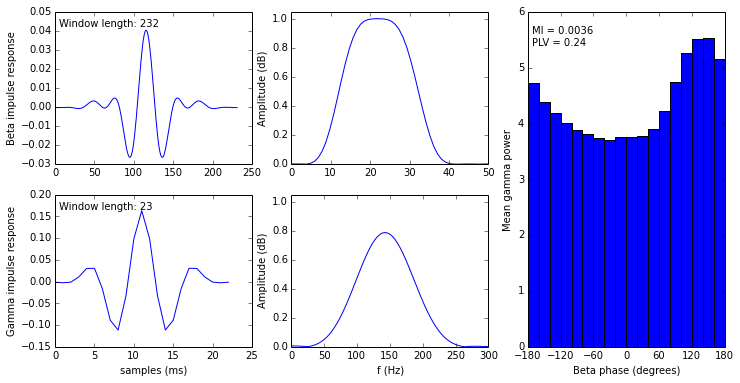

In [5]:
w=interactive(pacpretty,
              beta_center_freq = FloatSliderWidget(min = 12, max = 30, step = 0.5, value = 21.5),
              beta_bandwidth = FloatSliderWidget(min = 1, max = 20, step = 1, value = 17),
              beta_transition = FloatSliderWidget(min = 0.05, max = 0.95, step = 0.05, value = 0.15),
              beta_cycles = FloatSliderWidget(min = 2, max = 10, step = 1, value = 5),
              gamma_center_freq = FloatSliderWidget(min = 50, max = 200, step = 10, value = 140),
              gamma_bandwidth = FloatSliderWidget(min = 10, max = 100, step = 10, value = 60),
              gamma_transition = FloatSliderWidget(min = 0.05, max = 0.95, step = 0.05, value = 0.15),
              gamma_cycles = FloatSliderWidget(min = 0.5, max = 10, step = 0.5, value = 0.5))
display(w)